# Per cluster comparison & Celltype markers

In [396]:
import glob
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy import stats

from collections import OrderedDict
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from matplotlib.lines import Line2D

def nd(arr):
    return np.asarray(arr).reshape(-1)
def yex(ax):
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [397]:
data = anndata.read_h5ad("write/data.h5ad")
markers = pd.read_csv("write/markers_gene.csv", index_col=0)

In [398]:
age_map = {
    "SRR8426358": 24,
    "SRR8426359": 24,
    "SRR8426362": 24,
    "SRR8426363": 24,
    "SRR8426364": 24,
    "SRR8426369": 24,
    "SRR8426370": 24,
    "SRR8426360": 3,
    "SRR8426361": 3,
    "SRR8426365": 3,
    "SRR8426366": 3,
    "SRR8426367": 3,
    "SRR8426368": 3,
    "SRR8426371": 3,
    "SRR8426372": 3
}

## ACE2 Fraction of cells per cluster, old v young

In [399]:
gene = "Ace2"

In [400]:
assignments = data.obs.leiden.values.astype(int)
unique = np.unique(assignments)
mtx = data.layers["raw"]

In [401]:
gene_idx = np.where(data.var.index.values==gene)[0][0]
arr = nd(mtx[:,gene_idx].todense())

df = data.obs.copy()

df["ACE2"] = arr

In [402]:
print((arr>0).sum())
print(data.var.index.values[gene_idx])

180
Ace2


In [403]:
ace2 = df.groupby(["leiden","age"])["ACE2"].apply(lambda x: (x>0).sum())
ace2 = ace2.reset_index()
ace2 = ace2.rename(columns={"ACE2":"nnz"})
ace2["size"] = df.groupby(["leiden","age"])["ACE2"].apply(lambda x: len(x)).reset_index()["ACE2"]
ace2["frac"] = ace2["nnz"]/ace2["size"].astype(float)*100

In [404]:
ace2.head()

,leiden,age,nnz,size,frac
0,0,3,19,3275,0.580153
1,0,24,10,1007,0.993049
2,1,3,7,2694,0.259837
3,1,24,3,971,0.308960
4,2,3,5,2681,0.186498


In [405]:
ace2[ace2.leiden=='5']

,leiden,age,nnz,size,frac
10,5,3,54,1236,4.368932
11,5,24,22,504,4.365079


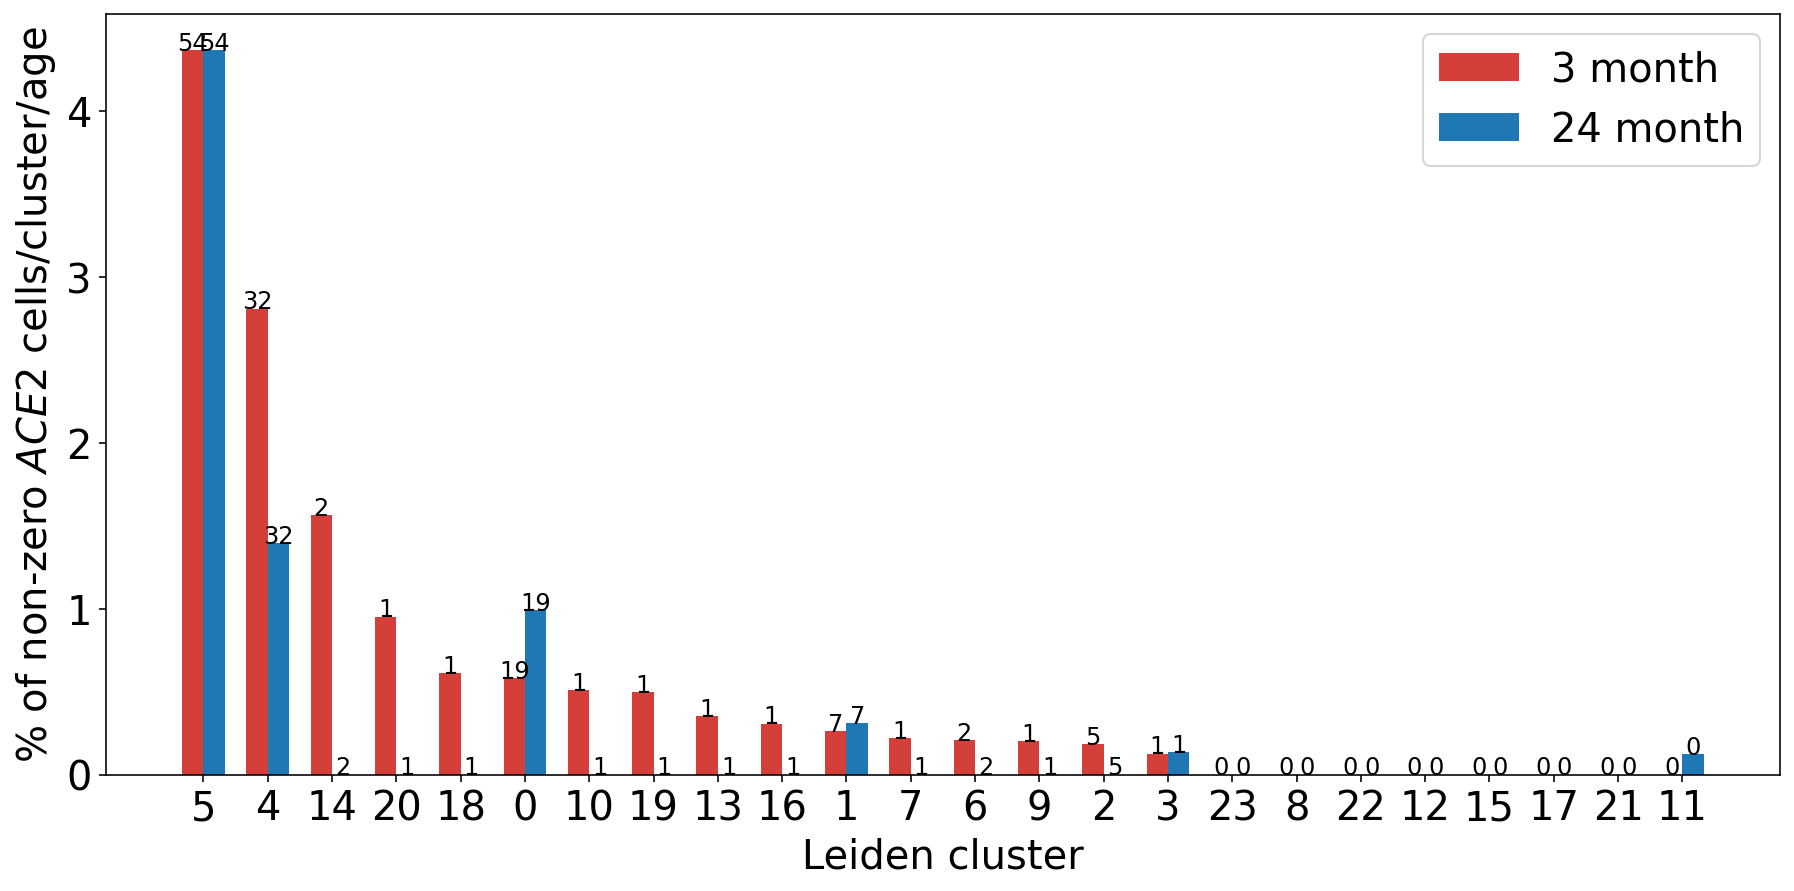

In [406]:
fig, ax = plt.subplots(figsize=(15,7))

labels = unique
lidx = np.arange(1, len(labels)*3+1, 3)

llabels = ["3 month"]*len(labels)
llidx = np.arange(0.5, len(llabels)*3, 3)

rlabels = ["24 month"]*len(labels)
rlidx = np.arange(1.5, len(rlabels)*3, 3)

young =  ace2[ace2["age"]==3]["frac"].values
nnz_young = ace2[ace2["age"]==3]["nnz"].values

old  =  ace2[ace2["age"]==24]["frac"].values
nnz_old = ace2[ace2["age"]==24]["nnz"].values


argsort = np.argsort(young)
young = young[argsort][::-1]
old = old[argsort][::-1]
labels = labels[argsort][::-1]
nnz_young = nnz_young[argsort][::-1]
nnz_old = nnz_old[argsort][::-1]

ax.bar(llidx, young, label="3 month", width=1, color="#D43F3A")
ax.bar(rlidx, old, label="24 month", width=1, color="#1f77b4")

for tn, t in enumerate(nnz_young):
    ax.text(llidx[tn], young[tn], str(t), ha="center", fontsize=12)
    ax.text(rlidx[tn], old[tn], str(t), ha="center", fontsize=12)

ax.set_xticks(lidx)
ax.set_xticklabels(labels)
ax.legend()
ax.set_xlabel("Leiden cluster")
ax.set_ylabel("% of non-zero $ACE2$ cells/cluster/age")
# ax.set_ylabel("Number of non-zero $ACE2$ cells/cluster/age")

plt.show()

# Labelling all of the clusters

In [407]:
unique = np.unique(markers.leiden.values)

## Load reference atlases

In [408]:
h = pd.read_csv("write/quake_lung_markers.csv", index_col=0)

In [409]:
h.head()

,Gene,avg_logFC,pct_in_cluster,pct_out_cluster,p_val,p_val_adj,TF,Receptor,Ligand,Enzymes,OMIM,GWAS,MCC,celltype
0,SCGB3A2,3.40,0.97,0.68,0.000000e+00,0.000000e+00,NaN,NaN,True,NaN,True,NaN,NaN,Club
1,CYP2B7P,1.11,0.89,0.52,1.635821e-167,4.332472e-163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Club
2,MGP,2.23,0.57,0.20,1.467882e-159,3.887686e-155,NaN,NaN,NaN,NaN,True,NaN,NaN,Club
3,RPLP2,0.60,1.00,0.98,2.025101e-133,5.363479e-129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Club
4,RNASE1,1.06,0.98,0.72,1.266665e-123,3.354762e-119,NaN,NaN,NaN,NaN,NaN,NaN,True,Club


In [410]:
m = pd.read_excel("../reference/marker_genes_cell_types.xlsx")

In [411]:
m.head()

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
0,0.0,2.815113,0.968,0.214,0.0,Alveolar_macrophage,Chi3l3
1,0.0,2.564033,0.924,0.205,0.0,Alveolar_macrophage,Ccl6
2,0.0,2.465148,0.641,0.050,0.0,Alveolar_macrophage,Ear2
3,0.0,2.284334,0.553,0.032,0.0,Alveolar_macrophage,Atp6v0d2
4,0.0,2.038324,0.549,0.056,0.0,Alveolar_macrophage,Mrc1


### iterate through all

In [412]:
np.repeat(unique, 10)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

In [413]:
anno = ["krasnow"]*2 + ["schiller"]*2

In [414]:
anno*4

['krasnow',
 'krasnow',
 'schiller',
 'schiller',
 'krasnow',
 'krasnow',
 'schiller',
 'schiller',
 'krasnow',
 'krasnow',
 'schiller',
 'schiller',
 'krasnow',
 'krasnow',
 'schiller',
 'schiller']

In [415]:
leiden = np.repeat(unique, 4)

In [416]:
len(leiden)

96

In [417]:
anno

['krasnow', 'krasnow', 'schiller', 'schiller']

In [418]:
df = pd.DataFrame({"leiden":leiden, "annotation":anno*24, "celltype":0, "vc":0})

In [419]:
df.head()

,leiden,annotation,celltype,vc
0,0,krasnow,0,0
1,0,krasnow,0,0
2,0,schiller,0,0
3,0,schiller,0,0
4,1,krasnow,0,0


In [420]:
a = h[h.Gene.isin(markers[markers["leiden"]==0].gene_name.str.upper())].celltype.value_counts()[:2]
b = m[m.gene.isin(markers[markers["leiden"]==0].gene_name)].cluster.value_counts()[:2]

c = a.append(b)

for un, u in enumerate(unique[1:]):
    a = h[h.Gene.isin(markers[markers["leiden"]==u].gene_name.str.upper())].celltype.value_counts()[:2]
    b = m[m.gene.isin(markers[markers["leiden"]==u].gene_name)].cluster.value_counts()[:2]
    c = c.append(a.append(b))
    
specific_cluster = 4

In [421]:
df["celltype"] = c.index
df["vc"] = c.values

In [422]:
df[df.leiden==0]

,leiden,annotation,celltype,vc
0,0,krasnow,Signaling Alveolar Epithelial Type 2,29
1,0,krasnow,Alveolar Epithelial Type 2,28
2,0,schiller,Type_2_pneumocytes,88
3,0,schiller,Alveolar_macrophage,82


In [423]:
from matplotlib import patches

In [424]:
ct = [[df[df.leiden==i].celltype.values[0], df[df.leiden==i].celltype.values[2]] for i in unique]
labels = ["/".join(i) for i in ct]

In [425]:
lidx = np.arange(3, len(labels)*4+3, 3)

In [426]:
lidx

array([ 3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51,
       54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96])

In [427]:
import matplotlib.lines as mlines

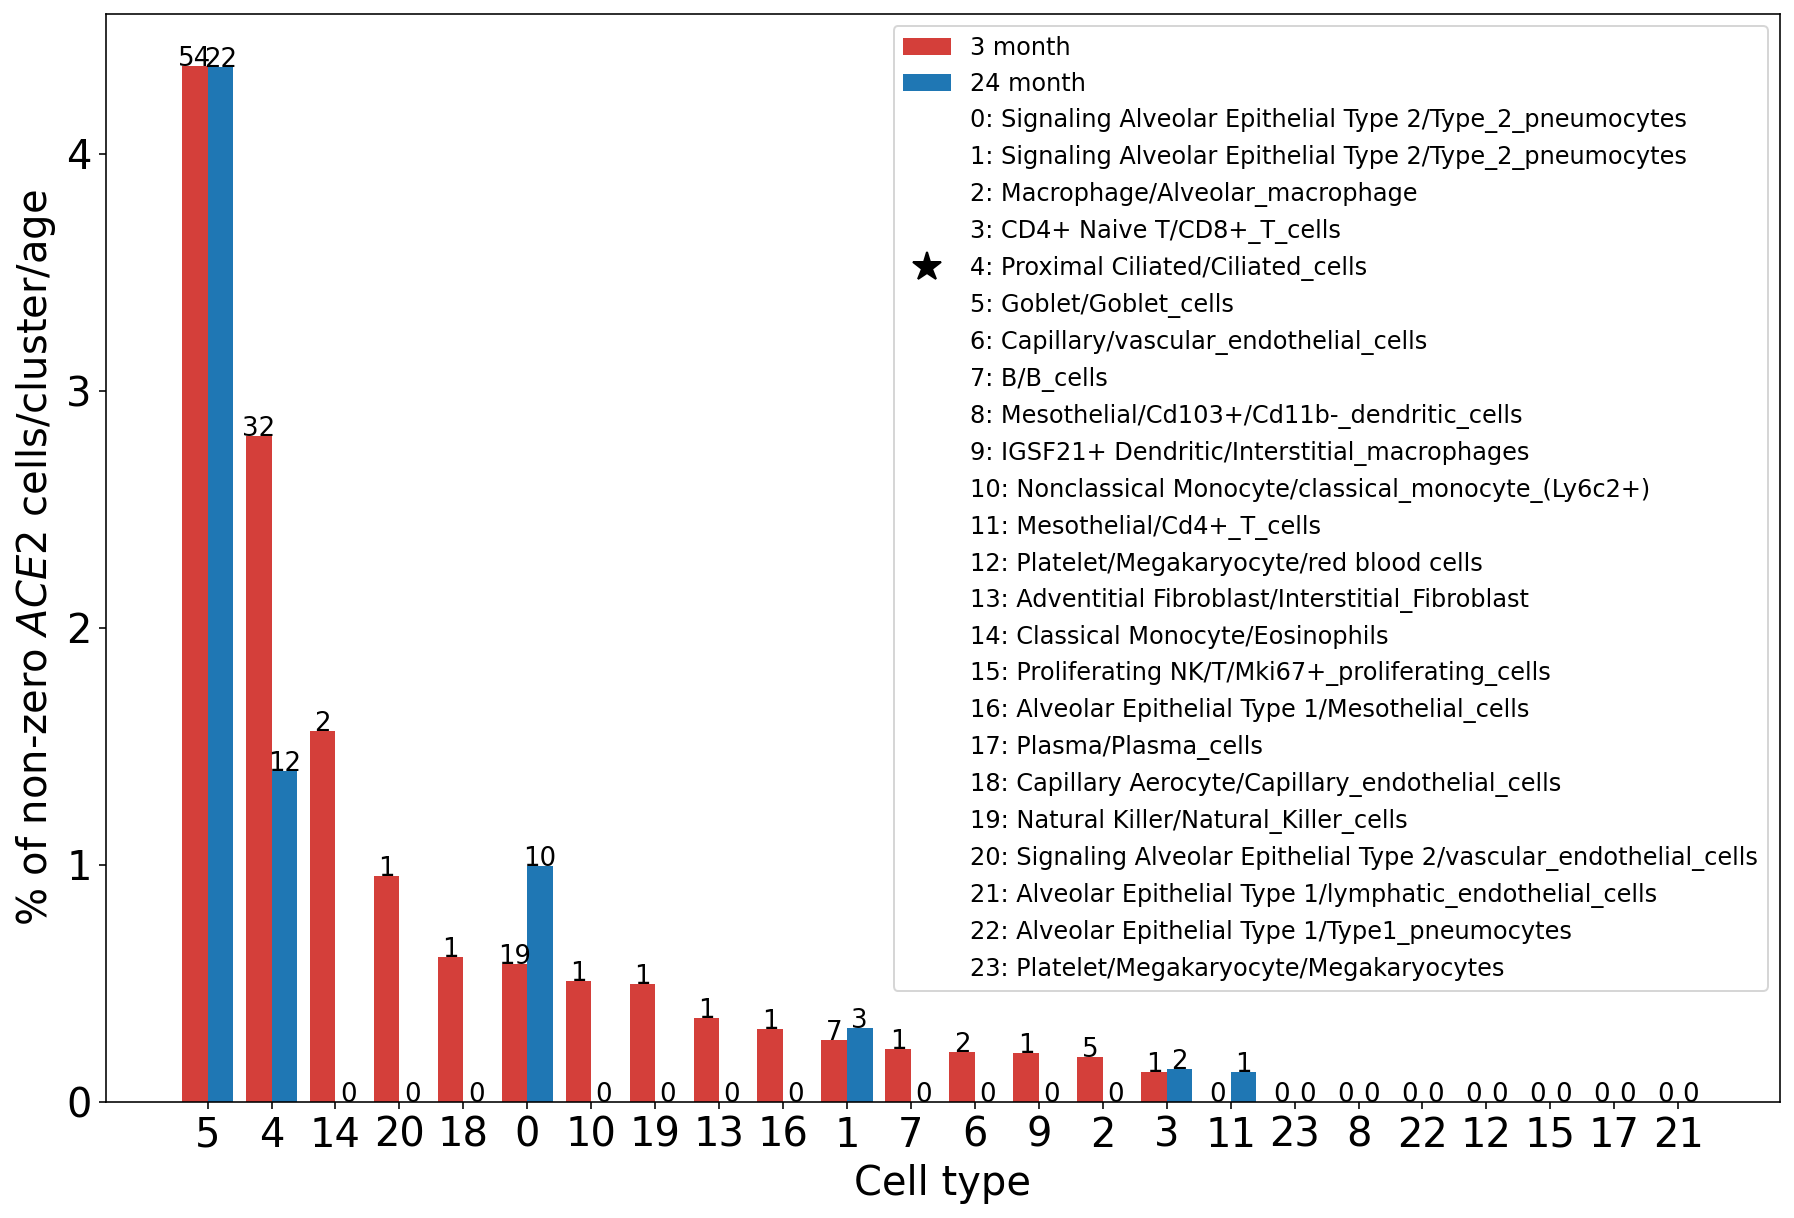

In [430]:
fig, ax = plt.subplots(figsize=(15,10))

ct = [[df[df.leiden==i].celltype.values[0], df[df.leiden==i].celltype.values[2]] for i in unique]
labels = ["/".join(i) for i in ct]

leg_labels = []

for tn, (t, u) in enumerate(zip(labels, unique)):
    leg_labels.append("{}: {}".format(u, t))

order = np.array([ 5,  4, 14, 20, 18,  0, 10, 19, 13, 16,  1,  7,  6,  9,  2,  3,11, 23, 8, 22, 12, 15, 17, 21])
    
scale = len(unique)*5
skip = 5
lidx = np.arange(3, scale, skip)

llidx = np.arange(2, scale, skip)
rlidx = np.arange(4, scale, skip)

young =  ace2[ace2["age"]==3]["frac"].values
nnz_young = ace2[ace2["age"]==3]["nnz"].values

old  =  ace2[ace2["age"]==24]["frac"].values
nnz_old = ace2[ace2["age"]==24]["nnz"].values


argsort = order
young = young[argsort]
old = old[argsort]
labels = [labels[i] for i in argsort]
nnz_young = nnz_young[argsort]
nnz_old = nnz_old[argsort]


width = 2
ax.bar(llidx, young, label="3 month", width=width, color="#D43F3A")
ax.bar(rlidx, old, label="24 month", width=width, color="#1f77b4")

for tn, (ty, to) in enumerate(zip(nnz_young, nnz_old)):
    ax.text(llidx[tn], young[tn], str(ty), ha="center", fontsize=fsize-7)
    ax.text(rlidx[tn], old[tn], str(to), ha="center", fontsize=fsize-7)



ax.set_xticks(lidx)
ax.set_xticklabels(unique[argsort])

handles, l = ax.get_legend_handles_labels()

empty = patches.Rectangle((0,0), 1, 1, fill=False, edgecolor='none',visible=False)
star = mlines.Line2D([], [], color="black", marker='*',markersize=15, linestyle="None")

leg_handles = [empty]*len(leg_labels)
for ii, (u, i) in enumerate(zip(unique, leg_handles)):
    if u == 4:
        leg_handles[ii] = star


ax.legend(handles+leg_handles, l+leg_labels, bbox_to_anchor=(1,1), loc="upper right", fontsize=12)

ax.set_xlabel("Cell type")
ax.set_ylabel("% of non-zero $ACE2$ cells/cluster/age")

# ax.set_ylabel("Number of non-zero $ACE2$ cells/cluster/age")
#plt.savefig("./figs/ACE2_celltype_fraction_distribution.png", bbox_inches='tight',dpi=300)


plt.show()

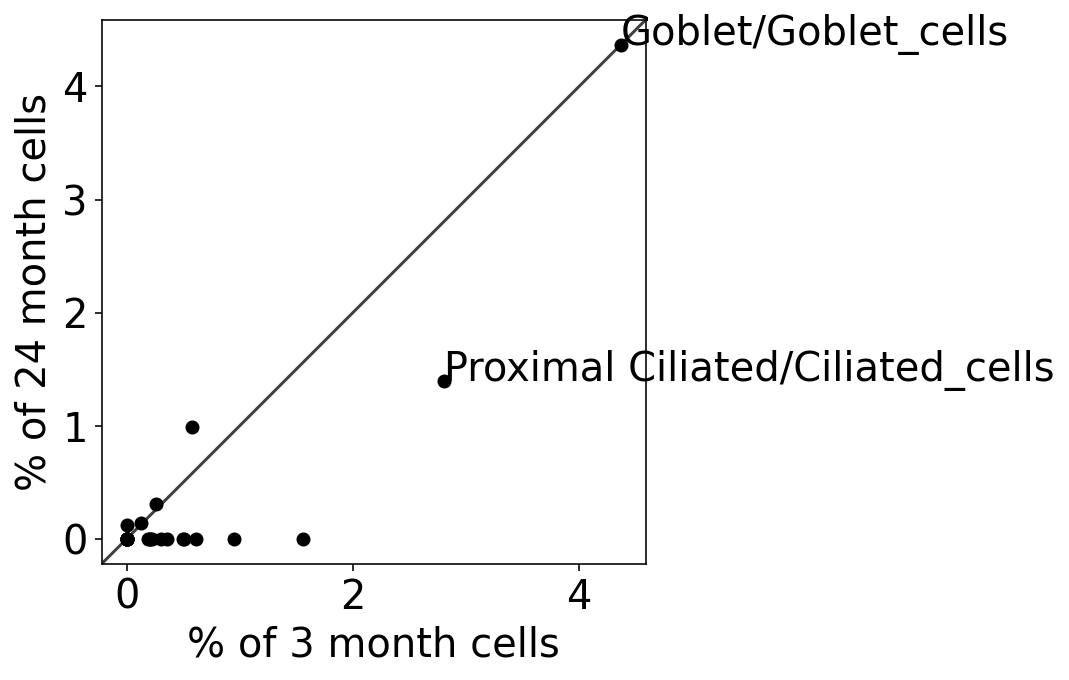

In [385]:
fig, ax = plt.subplots(figsize=(5,5))

x = young
y = old

ax.scatter(x, y, color="k")
yex(ax)

for tn, t in enumerate(labels):
    if x[tn]>0.5 and y[tn]>1: ax.annotate(t, (x[tn], y[tn]))

# ax.set_xlabel("% of 3 month cells")
# ax.set_ylabel("% of 24 month cells")

ax.set_xlabel("% of 3 month cells")
ax.set_ylabel("% of 24 month cells")

plt.savefig("./figs/ACE2_percent_old_v_young_cluster.png", bbox_inches='tight',dpi=300)

plt.show()

# Compare leiden 5 to 4 for young and old

In [288]:
df = data.obs.copy()

df["leiden"] = df.leiden.astype(int)

df = df[np.logical_or(df.leiden==5, df.leiden==4)]

In [295]:
df.groupby(["SRR", "leiden"])["leiden"].count()

SRR         leiden
SRR8426368  4          73
            5          85
SRR8426359  4         134
            5          25
SRR8426362  4         200
            5         130
SRR8426364  4          38
            5          16
SRR8426369  4         111
            5          58
SRR8426360  4          41
            5          49
SRR8426370  4          94
            5          34
SRR8426366  4         353
            5         315
SRR8426367  4          34
            5          86
SRR8426365  4          66
            5          71
SRR8426371  4         140
            5         213
SRR8426358  4          72
            5          29
SRR8426361  4         167
            5         176
SRR8426372  4         265
            5         241
SRR8426363  4         212
            5         212
Name: leiden, dtype: int64

In [324]:
idx = [
"SRR8426368",
"SRR8426359",
"SRR8426362",
"SRR8426364",
"SRR8426369",
"SRR8426360",
"SRR8426370",
"SRR8426366",
"SRR8426367",
"SRR8426365",
"SRR8426371",
"SRR8426358",
"SRR8426361",
"SRR8426372",
"SRR8426363"
]

In [326]:
tmp = df.groupby(["SRR", "leiden"])["leiden"].count()
cil = tmp.values[np.arange(0, len(tmp), 2)]
club = tmp.values[np.arange(1, len(tmp), 2)]
ratio = pd.DataFrame({"frac":club/cil}, index= idx)

In [327]:
ratio["age"] = ratio.index.map(age_map)

In [333]:
ratio.sort_values("age")

,frac,age
SRR8426368,1.164384,3
SRR8426360,1.195122,3
SRR8426366,0.892351,3
SRR8426367,2.529412,3
SRR8426365,1.075758,3
SRR8426371,1.521429,3
SRR8426361,1.053892,3
SRR8426372,0.909434,3
SRR8426359,0.186567,24
SRR8426362,0.650000,24


In [336]:
ratio.sort_values("age")

,frac,age
SRR8426368,1.164384,3
SRR8426360,1.195122,3
SRR8426366,0.892351,3
SRR8426367,2.529412,3
SRR8426365,1.075758,3
SRR8426371,1.521429,3
SRR8426361,1.053892,3
SRR8426372,0.909434,3
SRR8426359,0.186567,24
SRR8426362,0.650000,24


In [329]:
ratio.groupby("age")["frac"].mean()

age
3     1.292723
24    0.506375
Name: frac, dtype: float64

In [379]:
young = ratio[ratio.age==3]['frac'].values
old = ratio[ratio.age==24]['frac'].values
stat, p = stats.ttest_ind(young, old)

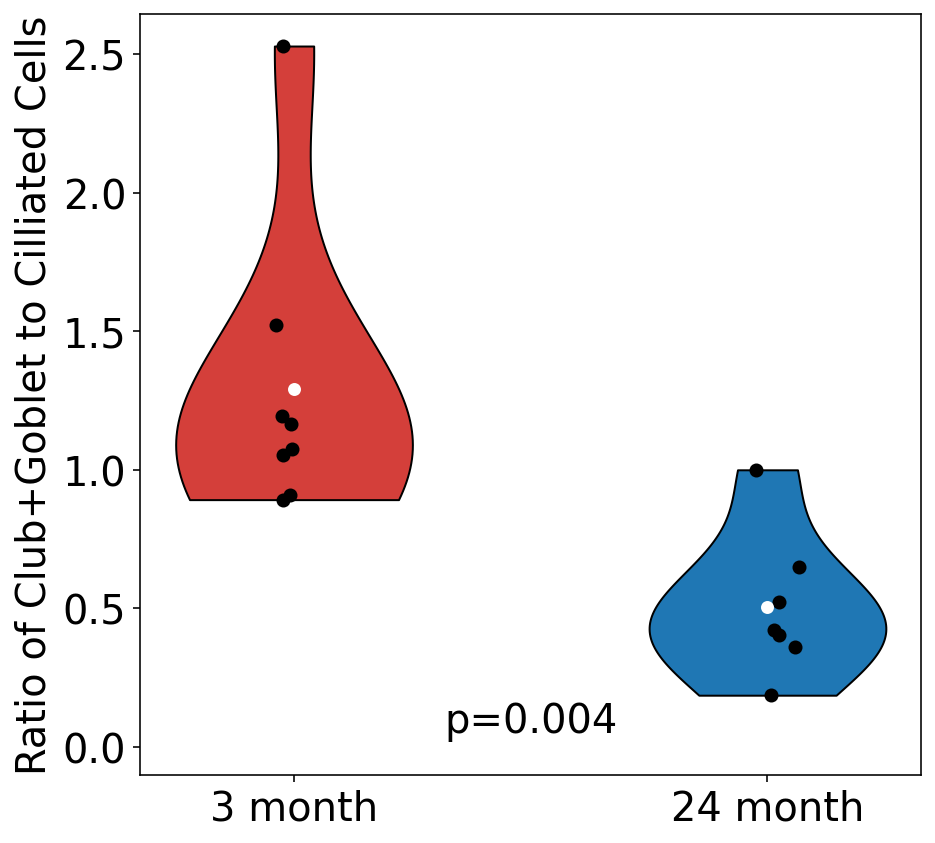

In [381]:
fig, ax = plt.subplots(figsize=(7,7))

gene = "ACE2"

labels = ['3 month', "24 month"]
lidx = [1, 2]


x = [young, old]

parts = ax.violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('#D43F3A')
    if pcidx==1: pc.set_facecolor('#1f77b4')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

    
mean = [np.mean(i) for i in x]
ax.scatter(lidx, mean, marker='o', color='white', s=30, zorder=3)


######## Add some random "jitter" to the x-axis
x = np.random.normal(1, 0.04, size=len(young))
ax.scatter(x, young, alpha=1, color="k")

x = np.random.normal(2, 0.04, size=len(old))
ax.scatter(x, old, alpha=1, color="k")

##########
ax.set_xticks(lidx)
ax.set_xticklabels(labels)



ax.annotate("p={:,.3f}".format(p), (1.5, ax.get_ylim()[1]*0.02), ha="center")

ax.set_ylim(-0.1)

ax.set_ylabel("Ratio of Club+Goblet to Cilliated Cells")
plt.savefig("./figs/club_goblet_cilia_ratio.png", bbox_inches='tight',dpi=300)

plt.show()

# Compare leiden 5 to 0 for young and old

In [386]:
df = data.obs.copy()

df["leiden"] = df.leiden.astype(int)

df = df[np.logical_or(df.leiden==5, df.leiden==0)]

In [387]:
df.groupby(["SRR", "leiden"])["leiden"].count()

SRR         leiden
SRR8426368  0         922
            5          85
SRR8426359  0          75
            5          25
SRR8426362  0         317
            5         130
SRR8426364  0          85
            5          16
SRR8426369  0         173
            5          58
SRR8426360  0         302
            5          49
SRR8426370  0         202
            5          34
SRR8426366  0         454
            5         315
SRR8426367  0         320
            5          86
SRR8426365  0         751
            5          71
SRR8426371  0         310
            5         213
SRR8426358  0          69
            5          29
SRR8426361  0          97
            5         176
SRR8426372  0         119
            5         241
SRR8426363  0          86
            5         212
Name: leiden, dtype: int64

In [388]:
idx = [
"SRR8426368",
"SRR8426359",
"SRR8426362",
"SRR8426364",
"SRR8426369",
"SRR8426360",
"SRR8426370",
"SRR8426366",
"SRR8426367",
"SRR8426365",
"SRR8426371",
"SRR8426358",
"SRR8426361",
"SRR8426372",
"SRR8426363"
]

In [389]:
tmp = df.groupby(["SRR", "leiden"])["leiden"].count()
zero = tmp.values[np.arange(0, len(tmp), 2)]
five = tmp.values[np.arange(1, len(tmp), 2)]
ratio = pd.DataFrame({"frac":five/zero}, index= idx)

In [390]:
ratio["age"] = ratio.index.map(age_map)

In [391]:
ratio.sort_values("age")

,frac,age
SRR8426368,0.092191,3
SRR8426360,0.162252,3
SRR8426366,0.693833,3
SRR8426367,0.268750,3
SRR8426365,0.094541,3
SRR8426371,0.687097,3
SRR8426361,1.814433,3
SRR8426372,2.025210,3
SRR8426359,0.333333,24
SRR8426362,0.410095,24


In [392]:
ratio.groupby("age")["frac"].mean()

age
3     0.729788
24    0.617235
Name: frac, dtype: float64

In [393]:
young = ratio[ratio.age==3]['frac'].values
old = ratio[ratio.age==24]['frac'].values
stat, p = stats.ttest_ind(young, old)

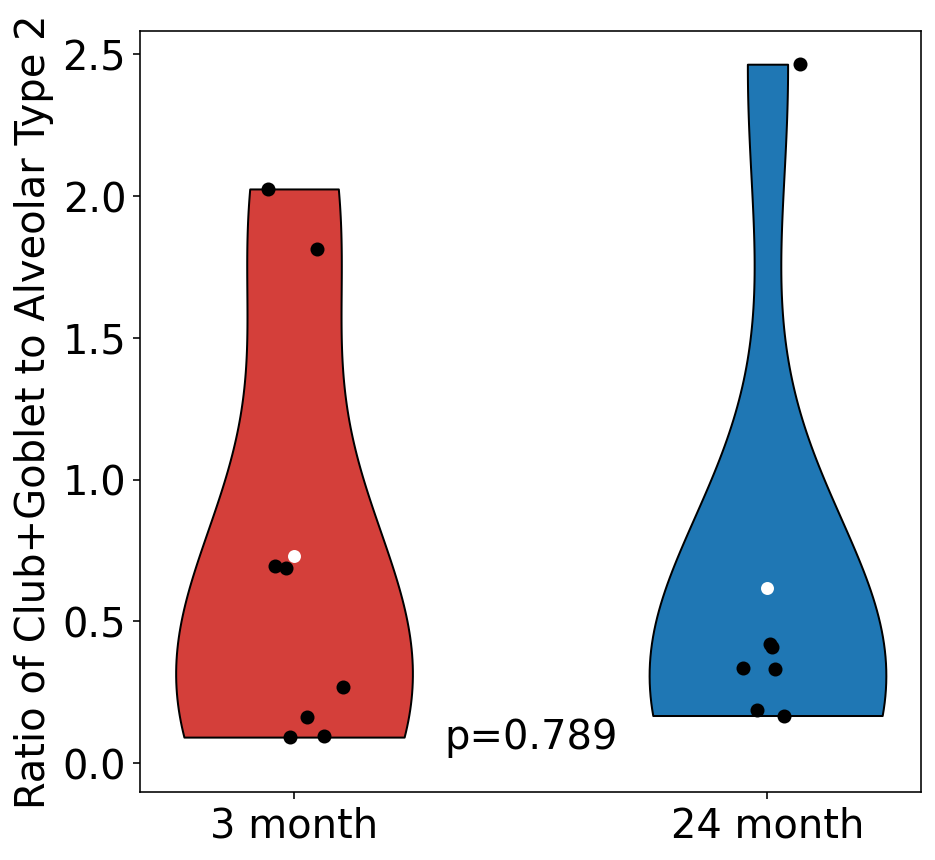

In [394]:
fig, ax = plt.subplots(figsize=(7,7))

gene = "ACE2"

labels = ['3 month', "24 month"]
lidx = [1, 2]


x = [young, old]

parts = ax.violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('#D43F3A')
    if pcidx==1: pc.set_facecolor('#1f77b4')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

    
mean = [np.mean(i) for i in x]
ax.scatter(lidx, mean, marker='o', color='white', s=30, zorder=3)


######## Add some random "jitter" to the x-axis
x = np.random.normal(1, 0.04, size=len(young))
ax.scatter(x, young, alpha=1, color="k")

x = np.random.normal(2, 0.04, size=len(old))
ax.scatter(x, old, alpha=1, color="k")

##########
ax.set_xticks(lidx)
ax.set_xticklabels(labels)



ax.annotate("p={:,.3f}".format(p), (1.5, ax.get_ylim()[1]*0.02), ha="center")

ax.set_ylim(-0.1)

ax.set_ylabel("Ratio of Club+Goblet to Alveolar Type 2")
plt.savefig("./figs/club_goblet_at2_ratio.png", bbox_inches='tight',dpi=300)

plt.show()